In [47]:
import numpy as np
import os
import matplotlib.pyplot as plt
import h5py
from scipy import interpolate
from ccfj import GetStationPairs
import pandas as pd
import yaml
import geopandas as gp
import openpyxl
from openpyxl import load_workbook
from concurrent.futures import ThreadPoolExecutor

from scipy.interpolate import make_interp_spline
from scipy.stats import ks_2samp
from scipy.spatial import ConvexHull

In [48]:
import sys
sys.path.append(r'../tools_F-J/')
from toollib_standard import maplib
from toollib_standard import mathlib
from toollib_standard import filelib
from toollib_standard import stacklib
from toollib_standard import plotlib

In [49]:
with open('a-project_repar.yml', 'r', encoding='utf-8') as f:
    proj = yaml.load(f.read(), Loader=yaml.FullLoader)
name_project = proj['name']
#name_project = 'project_repartrition/output_repar_03-01/'               # Harmon server
name_project

'project_repartition_v3.0/output_repar_01-01/'

In [50]:
with open('0_config.yml', 'r', encoding='utf-8') as f:
    dir_config = yaml.load(f.read(), Loader=yaml.FullLoader)
dir_project_workspace = dir_config['dir_project_workspace']
dir_CC_workspace = dir_config['dir_CC_workspace']
print('dir_CC_workspace: ', dir_CC_workspace)
print('dir_project_workspace: ', dir_project_workspace)
dir_project = os.path.join(dir_project_workspace, name_project)
print('dir_project: ', dir_project)

dir_CC_workspace:  /shdisk/rem2/Harmon/F-J/San/
dir_project_workspace:  /shdisk/rem2/Harmon/F-J/San/
dir_project:  /shdisk/rem2/Harmon/F-J/San/project_repartition_v3.0/output_repar_01-01/


In [51]:
filename = dir_project+'Basic_info.yml'
with open(filename, 'r', encoding='utf-8') as f:
    info_basic = yaml.load(f.read(), Loader=yaml.FullLoader)
filename_bi = dir_project+'Basic_info.npy'
info_basic_bi = np.load(filename_bi, allow_pickle='TRUE').item()      # setting dictionary

In [52]:
name_project_probes = info_basic['name_project_probes']
name_project_targets = info_basic['name_project_targets']
dir_project_probes = os.path.join(dir_project_workspace, name_project_probes)
dir_project_targets = os.path.join(dir_project_workspace, name_project_targets)
print('dir_project_probes: ', dir_project_probes)
print('dir_project_targets: ', dir_project_targets)

dir_project_probes:  /shdisk/rem2/Harmon/F-J/San/project/output_FJSJ_17-01/
dir_project_targets:  /shdisk/rem2/Harmon/F-J/San/project/output_FJSJ_17-02/


In [53]:
filename = dir_project_probes+'Basic_info.yml'
with open(filename, 'r', encoding='utf-8') as f:
    info_basic_probes = yaml.load(f.read(), Loader=yaml.FullLoader)
filename_bi = dir_project_probes+'Basic_info.npy'
info_basic_bi_probes = np.load(filename_bi, allow_pickle='TRUE').item()      # setting dictionary

filename = dir_project_targets+'Basic_info.yml'
with open(filename, 'r', encoding='utf-8') as f:
    info_basic_targets = yaml.load(f.read(), Loader=yaml.FullLoader)

filename = dir_project+'Basic_info.yml'
with open(filename, 'r', encoding='utf-8') as f:
    info_basic = yaml.load(f.read(), Loader=yaml.FullLoader)
filename_bi = dir_project+'Basic_info.npy'
info_basic_bi = np.load(filename_bi, allow_pickle='TRUE').item()      # setting dictionary

In [54]:
probes = info_basic_probes['key_subworks']
targets = info_basic_targets['key_subworks']
key_subworks = info_basic['key_subworks']

In [55]:
stalistname_all = info_basic['stalistname_all']
stainfo = pd.read_excel(stalistname_all)
nsta_all = len(stainfo.iloc[:,0])
StationPairs_all = GetStationPairs(nsta_all)
nPairs_all = int(len(StationPairs_all)/2)
stalist_all = stainfo['Station'].tolist()
lat_all = stainfo['latitude'].tolist() 
lon_all = stainfo['longitude'].tolist()

In [56]:
stalistname = dir_project+ info_basic['stalistname']
stainfo_all = pd.read_excel(stalistname,sheet_name=None)

stalistname = dir_project_probes+ info_basic_probes['stalistname']
stainfo_probes_all = pd.read_excel(stalistname,sheet_name=None)

stalistname = dir_project_targets+ info_basic_targets['stalistname']
stainfo_targets_all = pd.read_excel(stalistname,sheet_name=None)

In [57]:
stalistname = dir_project + 'subwork_location.xlsx'
loc_key = pd.read_excel(stalistname,sheet_name='location')
lat_key = loc_key['lat_centroid'].tolist()
lon_key = loc_key['lon_centroid'].tolist()

stalistname = dir_project_probes + 'subwork_location.xlsx'
loc_key_probes = pd.read_excel(stalistname,sheet_name='location')
key_probes = loc_key_probes['key_subwork'].tolist()
lat_key_probes = loc_key_probes['lat_centroid'].tolist()
lon_key_probes = loc_key_probes['lon_centroid'].tolist()

stalistname = dir_project_targets + 'subwork_location.xlsx'
loc_key_targets = pd.read_excel(stalistname,sheet_name='location')
key_targets = loc_key_targets['key_subwork'].tolist()
lat_key_targets = loc_key_targets['lat_centroid'].tolist()
lon_key_targets = loc_key_targets['lon_centroid'].tolist()

In [58]:
probe_accept_all = info_basic_bi['probe_accept']

In [59]:
faults = np.load('clark_faults.npy', allow_pickle='TRUE').item()

In [60]:
dir_image = dir_project + info_basic['dir_image']

In [61]:
# read disp data
disp_all = {}
ff_all = {}
for probe in key_probes:
    file_ds = dir_project_probes  + info_basic_probes['dir_disp'] + 'autopick_'+probe+'.txt'
    disp_all[probe] = np.loadtxt(file_ds,delimiter=',')[:,1]
    ff_all[probe] = np.loadtxt(file_ds,delimiter=',')[:,0]

In [62]:
# read F-J spectrogram
ds_probe_all = {}
for probe in key_probes:
    file_ds = dir_project_probes  + info_basic_probes['dir_ds'] + 'ds_'+probe+'.h5'
    ds = h5py.File(file_ds,'r')
    ds_probe_all[probe] = ds['ds_remove'][0]
    ds.close()

### Analysis

In [63]:
def new_target_comparison(key_subwork):
    global key_subworks
    global c_lim
    global dir_image
    global info_basic_bi
    global info_basic_bi_probes
    global info_basic_bi_targets
    global info_basic_probes
    global info_basic_targets
    global info_basic
    global stainfo_all
    global lat_all
    global lon_all
    global lat_key
    global lon_key
    global lat_key_probes
    global lon_key_probes
    global lat_key_targets
    global lon_key_targets
    global faults
    global probe_accept_all
    global disp_all
    global stainfo_targets_all

    target = key_subwork[:key_subwork.find('--')]
    probes = info_basic_bi['probe'][key_subwork]
    probes_accept = probe_accept_all[target]

    # all stations
    stainfo = stainfo_all[key_subwork]
    lat_this = stainfo['latitude'].tolist() 
    lon_this = stainfo['longitude'].tolist()

    stainfo_target = stainfo_targets_all[target]
    lat_targets = stainfo_target['latitude'].tolist()
    lon_targets = stainfo_target['longitude'].tolist()

    fig = plt.figure(figsize=(14,10))
    # partition comparison
    ax = plt.subplot(221)
    ax.scatter(lon_all, lat_all,marker='.',color='k',s=1)
    ax.scatter(lon_key[key_subworks.index(key_subwork)], lat_key[key_subworks.index(key_subwork)],marker='o',color='b',s=50,label='New center')
    ax.scatter(lon_this, lat_this,marker='o',color='g',s=20,label='New partition')
    ax.scatter(lon_key_targets[key_targets.index(target)], lat_key_targets[key_targets.index(target)],marker='^',color='b',s=50,label='Target center')
    ax.scatter(lon_targets, lat_targets,marker='^',color='r',s=5,label= 'Target partition')
    for i in range(len(faults)):
        ax.plot(faults['clark'+str(i+1)]['lon'], faults['clark'+str(i+1)]['lat'], 'k--', lw=1)
    ax.axis('off')
    ax.legend()
    # probe accepted comparison
    ax = plt.subplot(222)
    ax.scatter(lon_all, lat_all,marker='.',color='k',s=1)
    ax.scatter(lon_this, lat_this,marker='o',color='g',s=5,label='New partition')
    ax.axis('off')
    for i in range(len(faults)):
        ax.plot(faults['clark'+str(i+1)]['lon'], faults['clark'+str(i+1)]['lat'], 'k--', lw=1)
    #ax.scatter(lon_targets, lat_targets,marker='^',color='b',s=5,label= 'Target partition')

    flag_label_probe =  1
    flag_label_probe_accept =  1
    for probe in probes:
        if probe in probes_accept:
            if flag_label_probe_accept:
                ax.scatter(lon_key_probes[key_probes.index(probe)], lat_key_probes[key_probes.index(probe)],marker='*',color='r',s=30,label='Accepted Porbe center')
                flag_label_probe_accept = 0
            else:
                ax.scatter(lon_key_probes[key_probes.index(probe)], lat_key_probes[key_probes.index(probe)],marker='*',color='r',s=30)
        else:
            if flag_label_probe:
                ax.scatter(lon_key_probes[key_probes.index(probe)], lat_key_probes[key_probes.index(probe)],marker='*',color='b',s=20,label='Porbe center')
                flag_label_probe = 0
            else:
                ax.scatter(lon_key_probes[key_probes.index(probe)], lat_key_probes[key_probes.index(probe)],marker='*',color='b',s=20)
    ax.legend()
    # all disp comparison
    ax = plt.subplot(223)
    for probe in probes:
        ax.scatter(ff_all[probe], disp_all[probe],label=probe,s=1)
    ax.set_ylim(c_lim)
    # accepted disp comparison
    ax = plt.subplot(224)
    flag_label_probe =  1
    flag_label_probe_accept =  1
    for probe in probes:
        if probe in probes_accept:
            if flag_label_probe_accept:
                ax.scatter(ff_all[probe], disp_all[probe],label='accepted',s=1)
                flag_label_probe_accept = 0
            else:
                ax.scatter(ff_all[probe], disp_all[probe],s=1)
        """
        else:
            if flag_label_probe:
                ax.scatter(f_sample, disp_all[probe],label="unaccepted",s=0.5,color='b')
                flag_label_probe = 0
            else:
                ax.scatter(f_sample, disp_all[probe],s=0.5,color='b')
        """
    ax.set_ylim(c_lim)
    ax.legend()
    plt.savefig(dir_image+'new_target_comparison_'+key_subwork+'.png',dpi=100)

In [64]:
def plot_disp_all(key_subwork):
    global key_subworks
    global c_lim
    global dir_image
    global info_basic_bi
    global info_basic_bi_probes
    global info_basic_bi_targets
    global info_basic_probes
    global f_lim
    global probes_accept
    

    f = info_basic_bi_probes['f']
    c = np.linspace(info_basic_probes['c_min'],info_basic_probes['c_max'],info_basic_probes['c_num'])
    num = len(probes)
    n_cols = int(np.ceil(np.sqrt(num)))
    n_rows = int(np.floor(np.sqrt(num)))
    fig = plt.figure(figsize=(n_cols*3,n_rows*2))
    for i in range(num):
        ax = plt.subplot(n_rows,n_cols,i+1)
        ax = plotlib.plot_fj(ax,ds_probe_all[probes[i]],probes[i],f,c,0,c_map='jet')
        ax.scatter(ff_all[probes[i]], disp_all[probes[i]],label=probes[i],s=1)
        ax.set_ylim(c_lim)
        ax.set_xlim(f_lim)
        ax.legend()
        if probes[i] in probes_accept:
            ax.set_title(probes[i]+' (accepted)',color='r')
        else:
            ax.set_title(probes[i],color='b')
    plt.tight_layout()
    plt.savefig(dir_image+'disp_all_'+key_subwork+'.png',dpi=60)

In [65]:
key_subwork = key_subworks[400]
key_subwork

'30-12--401'

In [66]:
c_lim = [0.3,0.75]
f_lim = [9,18]

target = key_subwork[:key_subwork.find('--')]
probes = info_basic_bi['probe'][key_subwork]
probes_accept = probe_accept_all[target]

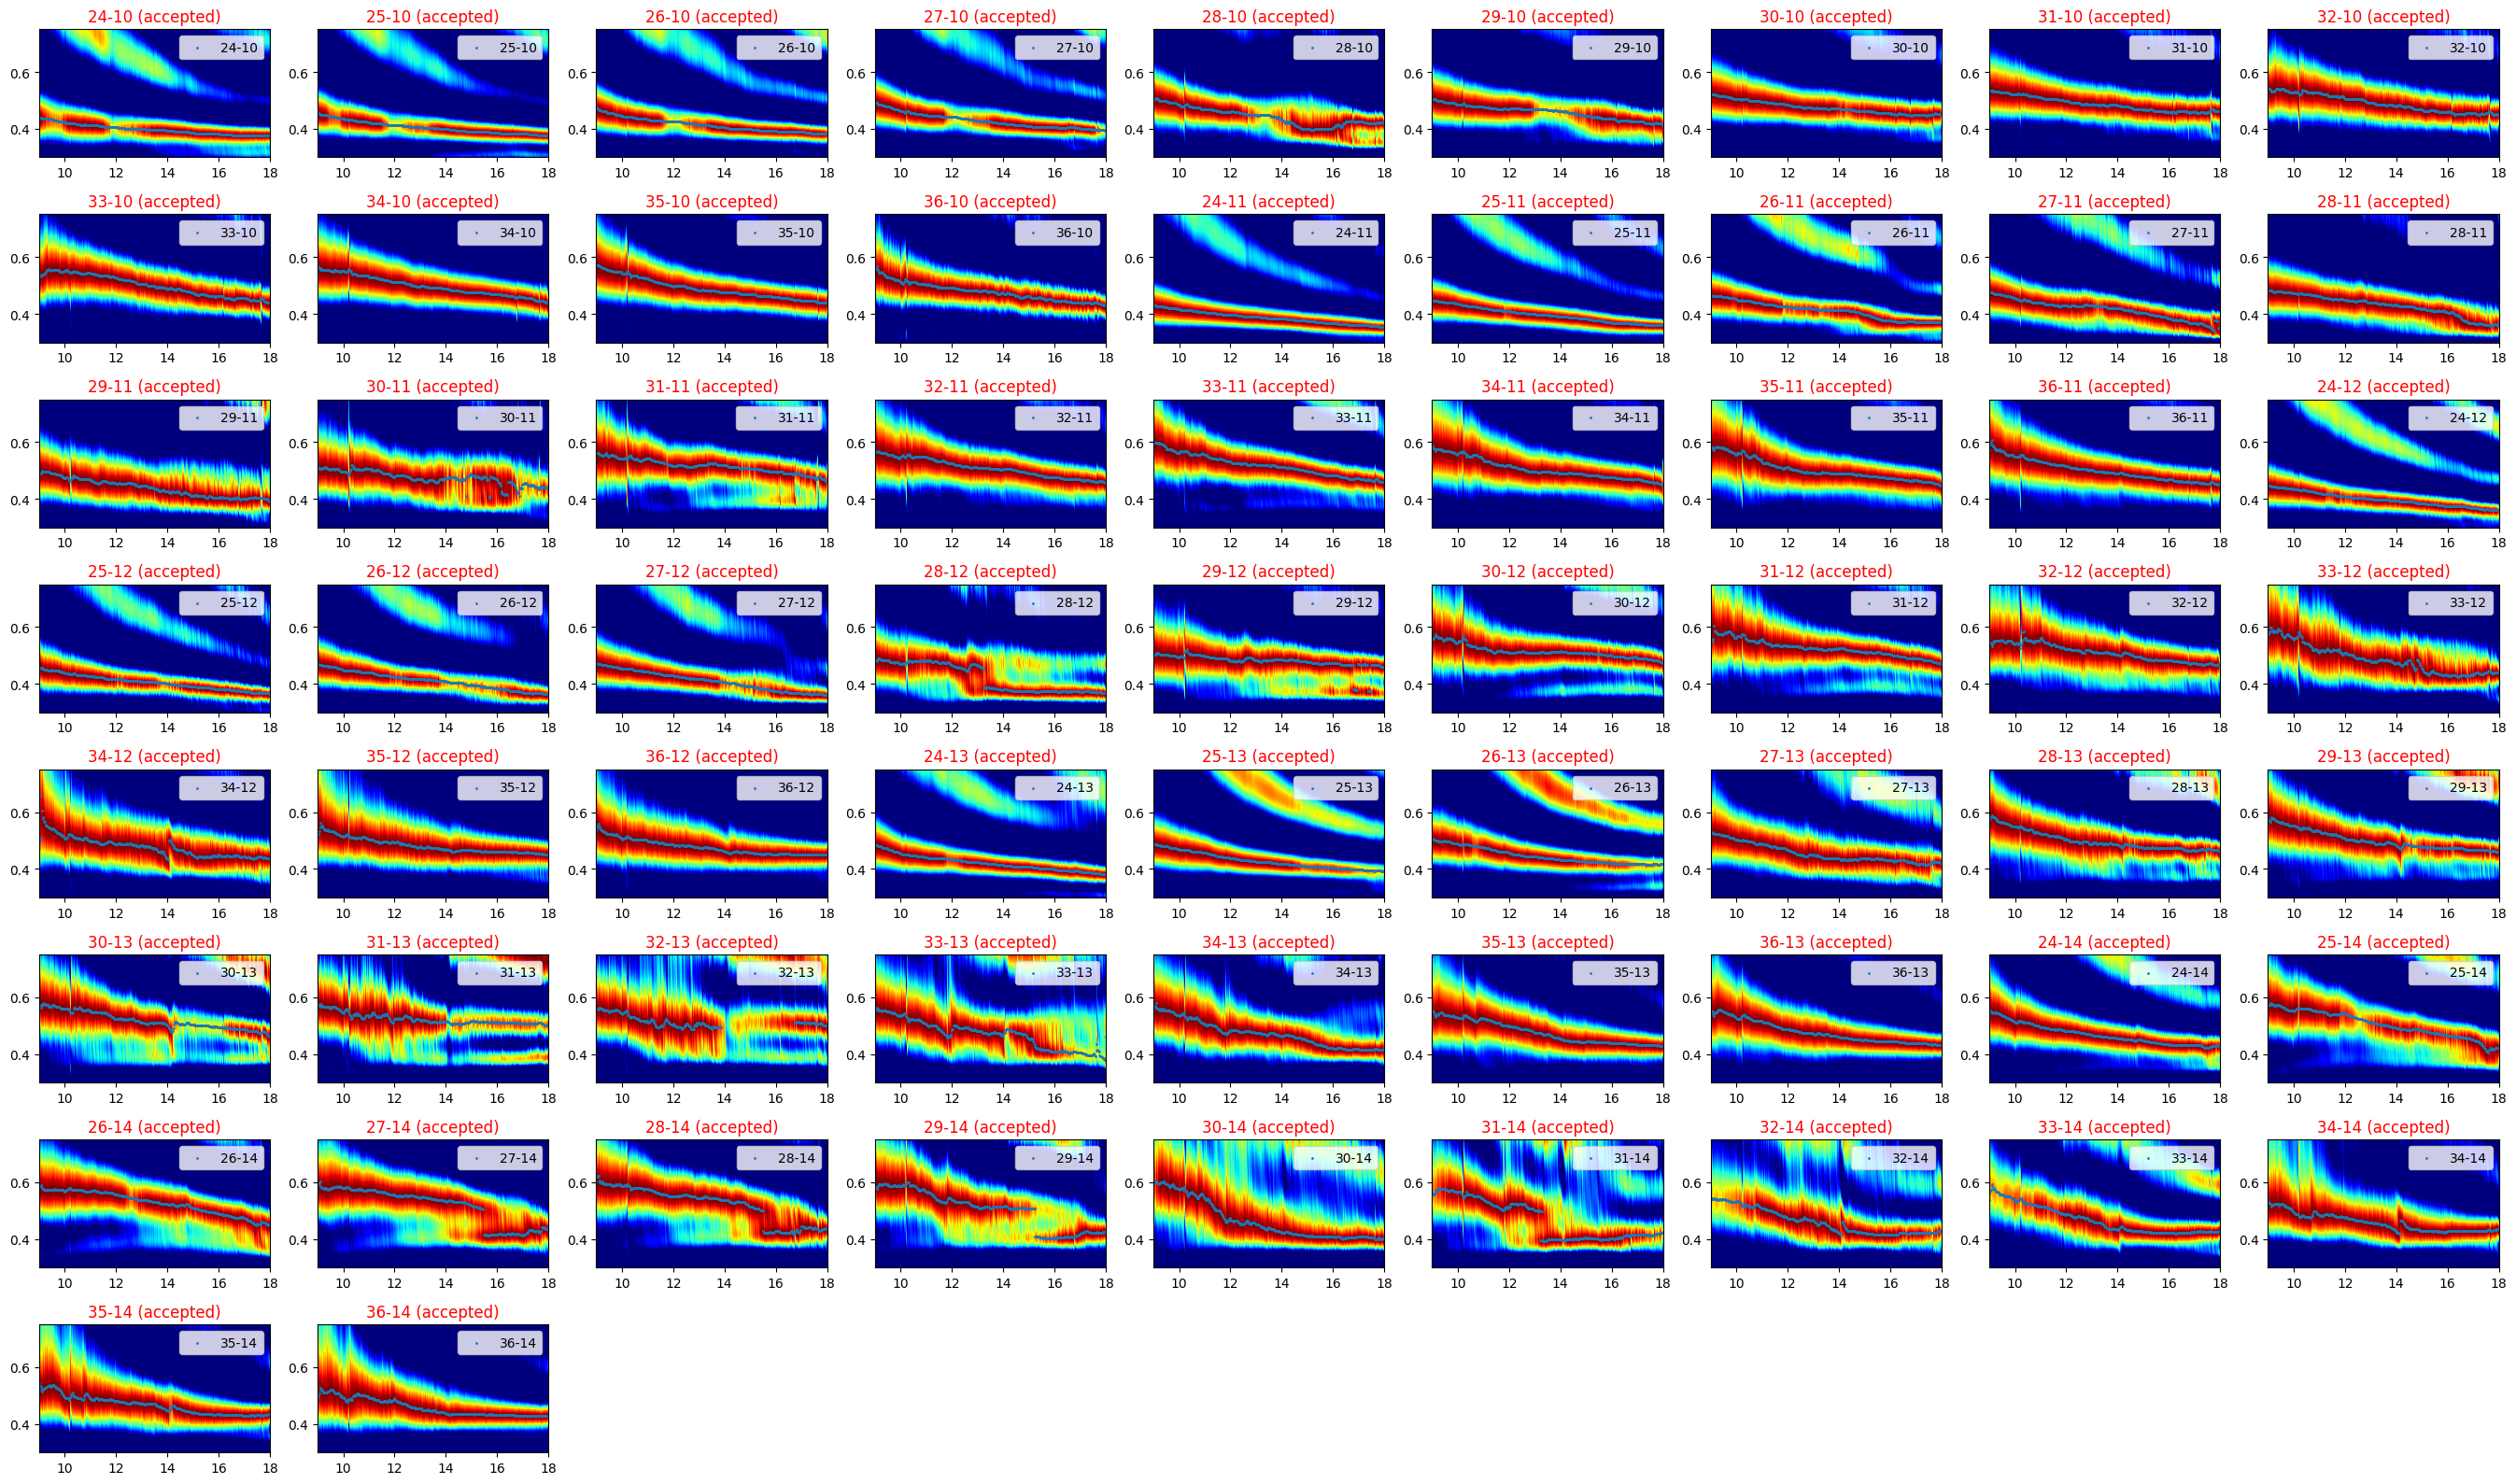

In [67]:
plot_disp_all(key_subwork)

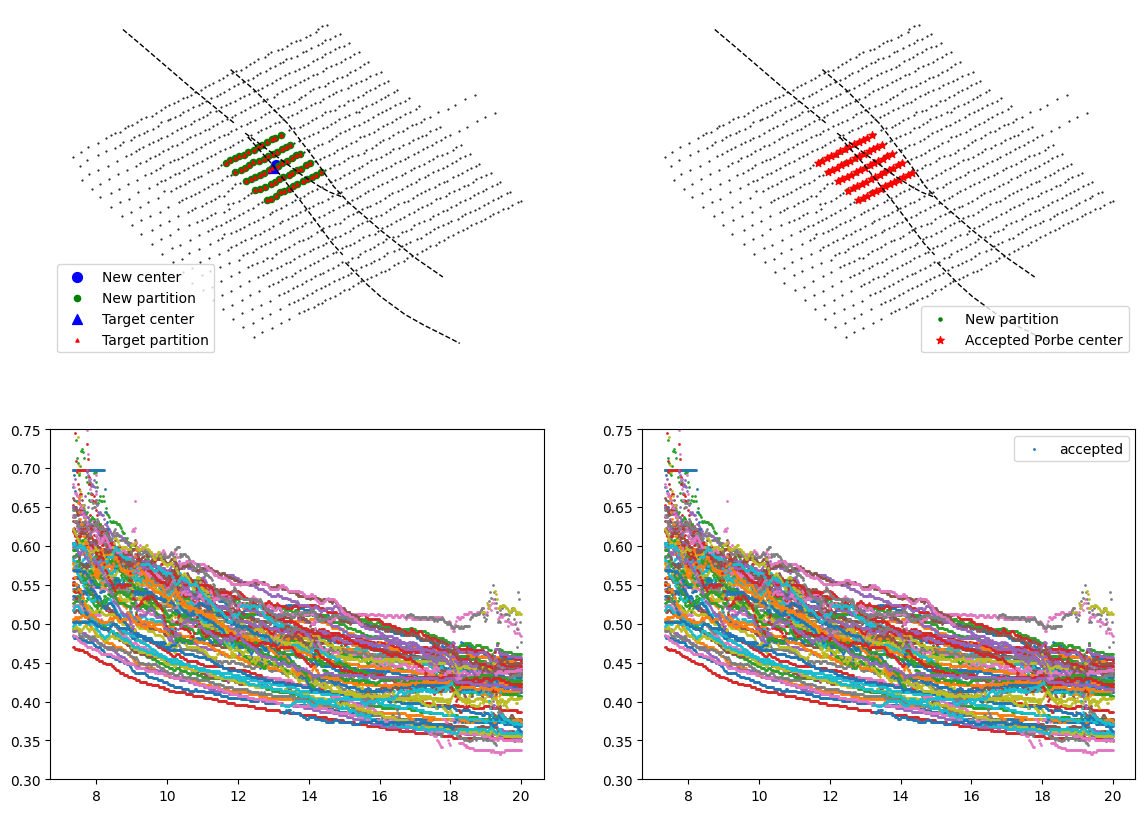

In [68]:
new_target_comparison(key_subwork)